## Correlating NAO and Overturning anomalies

In this notebook, we compute correlations between NAO and overturning anomalies. Since overturning strength could evolve in some definite time due to atmospheric forcing, we consider time-lagged correlation. Moreoever, oceans may retain memomry for some time. Thus, it might be more approapriate to use intergral definitions.

Assuming that surface heat flux anomalies, which are strongly correlated to NAO phases, affect overturning with some time lag, we could write the following


$\psi(y,t+\tau) \propto \int_{t_0}^{t}\text{NAO}dt$


In [1]:
# Load libraries

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40306,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:42196,Total threads: 1
Dashboard: http://127.0.0.1:39271/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:41240,


In [3]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")

print(ds_NAO)

<xarray.Dataset>
Dimensions:     (start_year: 57, r: 10, time: 125)
Coordinates:
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 2016
Dimensions without coordinates: r, time
Data variables:
    NAO         (start_year, r, time) float64 ...
    P_south     (start_year, r, time) float64 ...
    P_north     (start_year, r, time) float64 ...
    time_val    (start_year, time) object ...


In [4]:
ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

# variable list to keep in the dataset
var_list = ['hfbasin_atlantic', 'sltbasin_atlantic', 'zomsfatl']

ds = xr.open_dataset(ppdir+"Overturning_z.nc", decode_times=False, chunks={'r':1})
ds = ds.get(var_list)
ds = xr.decode_cf(ds)

print(ds)

<xarray.Dataset>
Dimensions:            (start_year: 57, r: 10, time_counter: 125, y: 451, x: 1, depthw: 75)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(451, 1), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(451, 1), meta=np.ndarray>
    time_centered      (start_year, time_counter) object dask.array<chunksize=(57, 125), meta=np.ndarray>
  * time_counter       (time_counter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
Dimensions without coordinates: r, y, x
Data variables:
    hfbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 451, 1), meta=np.ndarray>
    sltbasin_atlantic  (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 451, 1), meta=np.ndarray>
    zomsfatl           (start_year, r, time_counter, 

In [5]:
ppdir_drift="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_1970_2016_Method_DCPP/"

ds_drift = []

for lead_year in range(0, 11):
    
    d = xr.open_dataset(ppdir_drift + "diaptr/" + "Drift_diaptr_Lead_Year_" + 
                        str(lead_year + 1) + ".nc", decode_times= False)
    d = d.assign(time_counter = np.arange(lead_year*12, 12*lead_year + np.minimum(12, len(d['time_counter'])), 1))
    
    ds_drift.append(d)
    
ds_drift = xr.concat(ds_drift, dim='time_counter')

ds_drift = ds_drift.get(var_list)

print(ds_drift)

<xarray.Dataset>
Dimensions:            (r: 10, time_counter: 125, y: 451, x: 1, depthw: 75)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 3.997 4.246 4.495 ... 79.85 79.92 79.99
    nav_lon            (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * time_counter       (time_counter) int64 0 1 2 3 4 5 ... 120 121 122 123 124
    time_centered      (time_counter) float64 3.635e+09 3.638e+09 ... 3.646e+09
    start_year         (time_counter) int64 2016 2016 2016 ... 2006 2006 2006
Dimensions without coordinates: r, y, x
Data variables:
    hfbasin_atlantic   (r, time_counter, y, x) float32 1.415 1.411 ... 0.03427
    sltbasin_atlantic  (r, time_counter, y, x) float32 0.01166 ... -0.02729
    zomsfatl           (r, time_counter, depthw, y, x) float32 -0.04033 ... 0.0


In [6]:
ds = ds.drop('time_counter') 
ds_drift = ds_drift.drop(['time_counter','start_year'])

ds_anom = ds - ds_drift

psi_anom = ds.zomsfatl.mean(['x']).max(dim='depthw') - ds_drift.zomsfatl.mean(['x']).max(dim='depthw')

ds_anom['psi_anom'] = psi_anom #anomaly in psi max 

print(ds_anom)

<xarray.Dataset>
Dimensions:            (depthw: 75, y: 451, x: 1, start_year: 57, r: 10, time_counter: 125)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 3.997 4.246 4.495 ... 79.85 79.92 79.99
    nav_lon            (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
Dimensions without coordinates: y, x, r, time_counter
Data variables:
    hfbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 451, 1), meta=np.ndarray>
    sltbasin_atlantic  (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 451, 1), meta=np.ndarray>
    zomsfatl           (start_year, r, time_counter, depthw, y, x) float32 dask.array<chunksize=(57, 1, 125, 75, 451, 1), meta=np.ndarray>
    psi_anom           (start_year, r, time_counter, y) float32 dask.array<chunksize=(57, 1, 125, 45

### Start with NAO+ in first DJF

If we treat all hindcasts the same, we effectively have 10*57 = 570 ensemble members. In the figure below, we have plotted NAO indices for every month for each ensemble member. It is clear that we observe extreme NAO patterns in winter months when the jet stream is the strongest.

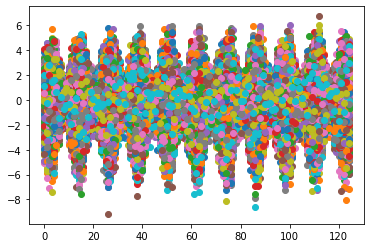

In [6]:
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(ds_NAO['NAO'].isel(start_year=year, r=r),'o')

#### Seasonal dependence

At first, instead of looking at all members, we look at runs that have strong positive (or negative) NAO phase in the first DJF. We set cutoff for NAO+ indices to be greater than 2. we then examine how the system evolves over time and how surface properties change. For this, we first compute seasonal-mean NAO indices and isolate members having NAO > 2. in first DJF.

In [8]:
NAO_season = ds_NAO['NAO'].copy()
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg
NAO_season = NAO_season.resample(time='QS-DEC').mean('time')

Text(0, 0.5, 'NAO')

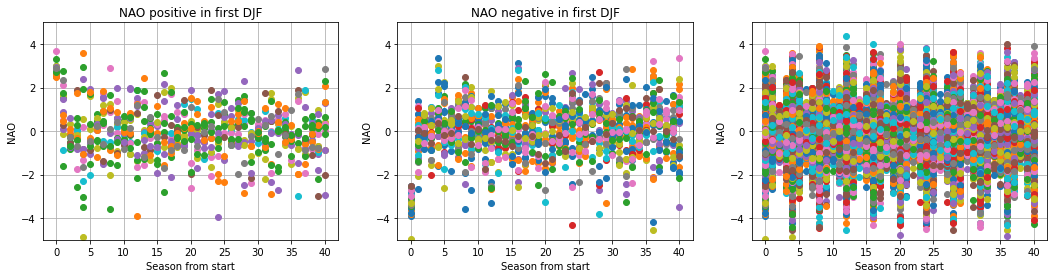

In [8]:
fig = plt.figure(figsize=[18,4])


plt.subplot(1,3,1)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_season.isel(start_year=year, r=r).where(NAO_season.isel(start_year=year, r=r,time=0) >= 2.5), 'o')
        
plt.grid('on')
plt.ylim([-5, 5])
plt.xlabel('Season from start')
plt.ylabel('NAO')
plt.title('NAO positive in first DJF')

plt.subplot(1,3,2)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_season.isel(start_year=year, r=r).where(NAO_season.isel(start_year=year, r=r,time=0) <= -2.5),'o')
        
plt.grid('on')
plt.ylim([-5, 5])
plt.xlabel('Season from start')
plt.ylabel('NAO')
plt.title('NAO negative in first DJF')

tmp = NAO_season.isel(time=0)

plt.subplot(1,3,3)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_season.isel(start_year=year, r=r),'o')
        
plt.grid('on')
plt.ylim([-5, 5])
plt.xlabel('Season from start')
plt.ylabel('NAO')

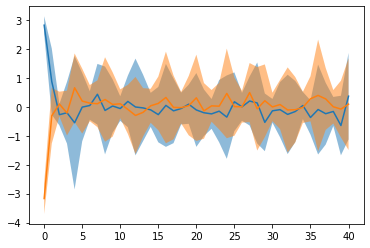

In [9]:
tmp1 = NAO_season.where(NAO_season.isel(time=0) >= 2.5).mean(['start_year','r'])
tmp1_std = NAO_season.where(NAO_season.isel(time=0) >= 2.5).std(['start_year','r'])
tmp2 = NAO_season.where(NAO_season.isel(time=0) <= -2.5).mean(['start_year','r'])
tmp2_std = NAO_season.where(NAO_season.isel(time=0) <= -2.5).std(['start_year','r'])

plt.plot(tmp1)
plt.fill_between(range(0,41), tmp1 - tmp1_std, tmp1 + tmp1_std, alpha=0.5)
plt.plot(tmp2)
plt.fill_between(range(0,41), tmp2 - tmp2_std, tmp2 + tmp2_std, alpha=0.5)

In [10]:
count_NAOp = xr.where(NAO_season.isel(time=0) >= 2.5, 1, 0)
count_NAOn = xr.where(NAO_season.isel(time=0) <= -2.5, 1, 0)

print(count_NAOp.sum(), count_NAOn.sum())

<xarray.DataArray 'NAO' ()>
array(16)
Coordinates:
    time     object 1960-12-01 00:00:00 <xarray.DataArray 'NAO' ()>
array(30)
Coordinates:
    time     object 1960-12-01 00:00:00


#### Overturning Anomalies

We can follow the same for overturning and look at time series of overturning anomalies that had strong +ve/-ve NAO phases in the first DJF.

In [11]:
psi_max= ds_anom['psi_anom'].rename({'time_counter':'time'})
psi_max = psi_max.assign_coords(y=ds_anom.nav_lat.isel(x=0), time=tim)
psi_max = psi_max.isel(time=slice(1,len(psi_max['time'])-1))
psi_season = psi_max.resample(time='QS-DEC').mean('time').persist()
#psi_month = psi_month.sel(y= [30.,  50.], method="nearest")

In [12]:
print(psi_season, NAO_season)

<xarray.DataArray 'psi_anom' (start_year: 57, r: 10, time: 41, y: 451)>
dask.array<transpose, shape=(57, 10, 41, 451), dtype=float32, chunksize=(57, 1, 1, 451), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) object 1960-12-01 00:00:00 ... 1970-12-01 00:00:00
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 2016
    nav_lat     (y) float32 3.997 4.246 4.495 4.745 ... 79.78 79.85 79.92 79.99
    nav_lon     (y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * y           (y) float32 3.997 4.246 4.495 4.745 ... 79.78 79.85 79.92 79.99
Dimensions without coordinates: r <xarray.DataArray 'NAO' (start_year: 57, r: 10, time: 41)>
array([[[-3.52676437,  1.38696039, -0.09877206, ..., -0.94451636,
          1.66859677, -1.98698763],
        [-1.52204035,  0.87589685, -0.34513763, ..., -1.05085867,
          0.27484979, -1.4705903 ],
        [ 0.53243847, -0.74598573, -0.81622954, ..., -0.47273989,
         -0.02701503, -0.14144109],
        .

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exc

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Res

KilledWorker: ("('open_dataset-4e8b8fed0653b43e1bba7716c914b2b3zomsfatl-41c9828fca7360f0b0a0129506eeeded', 0, 9, 0, 0, 0, 0)", <WorkerState 'tcp://127.0.0.1:40966', name: 2, status: closed, memory: 0, processing: 4>)

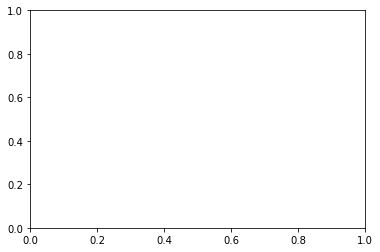

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Res

In [13]:
tmp = ((psi_season.sel(y= [45.,  55.], method="nearest"))
        .where(NAO_season.isel(time=0) >= 2.5).mean(['start_year','r']))
tmp_std = ((psi_season.sel(y= [45.,  55.], method="nearest"))
           .where(NAO_season.isel(time=0) >= 2.5).std(['start_year','r']))

for y in range(0,len(tmp.y)):
    plt.plot(tmp.isel(y=0), lw=2.)
    plt.fill_between(range(0,41), (tmp1 - tmp1_std).isel(y=y), (tmp1 + tmp1_std).isel(y=y), alpha=0.5)


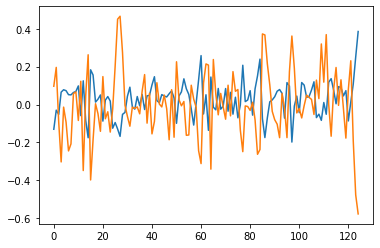

In [19]:
HT = ds_anom['hfbasin_atlantic'].mean('x')
HT = HT.assign_coords(y=ds.nav_lat.isel(x=0))

plt.plot(HT.sel(start_year=1967,r=0).sel(y=50., method="nearest"))

plt.plot(ds_NAO['NAO'].sel(start_year=1967,r=0)/10.)

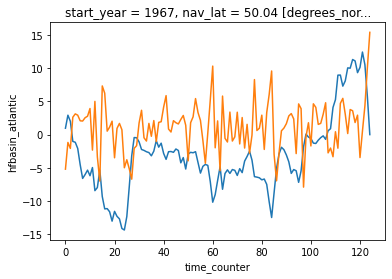

In [31]:
ds_NAO['NAO'].sel(start_year=1967,r=0).cumsum('time').plot()
(HT*40.).sel(start_year=1967,r=0).sel(y=50., method="nearest").plot()

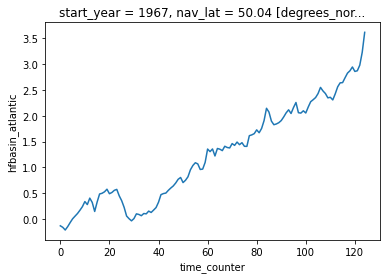

In [26]:
HT.sel(start_year=1967,r=0).sel(y=50., method="nearest").cumsum('time_counter').plot()